In [ ]:
# GOAL : What am I searching for ?
        # => To predict with the best possible accuracy (proba) an event (+/- xx% variation of close_price)
        # What for ?
            # => To be able to balance my portfolio (sell what should go down for what should go up)
            # => Sell crypto for Stable coin / Or buy crypto with Stable Coin
########

# Advices : 
    # Be careful to scaling, min / max can change in the future...

In [ ]:
# DONE
    # 1 / Industrialization : 
        # Dataset for TOP 20 cryptos + capacity to learn from top 20 and predict 1 : DONE !
    # 2 / Gérer le fait qu'on a des datasets déséquilibrés ? : OK
    # 3 / Gérer l'overfitting de ouf : OK
    # 4 / Play with Treshold
    # 4 bis / 
        # => ROC Curve, learning curve & precision / recall curve au top et bien comprendre !       
            # => Lire tout : https://classeval.wordpress.com/introduction/introduction-to-the-roc-receiver-operating-characteristics-plot/
        # => cf. schéma avec 2 lignes de Treshold. Le treshold ça marche comment ? Il est ou sur precision ou recall ? 
        # => Est-ce que ça a un sens ?? Bien comprendre !

In [ ]:
# TODO Now :
    # 4 bis : 
        # Trouver un moyen pour que le ranking des modèles créés par GridSearch soit estimé en fonction de :
            # precision + pas d'overfitting (scores train / test à peu près identiques)
    
    # 5 / Coder la systématisation :
        # -> Dataset original 1-20-40 cryptos
        # -> Prédire 1 / plusieurs cryptos (plusieurs plus logique ?)
        # -> Algo XGBoostC, RandomForestC, MLPC
        # Différents y (increase / deacrease + due date):
            # +3h  : (+/-) 2.5 / 5% / 7.5% / 10%
            # +6h  : (+/-) 2.5 / 5% / 7.5% / 10%
            # +12h : (+/-) 5% / 7.5% / 10%
            # +1d  : (+/-) 5% / 7.5% / 10%
            # +2d  : (+/-) 5% / 7.5% / 10%
            # +3d  : (+/-) 5% / 10% / 15% / 20%
            # +7d  : (+/-) 10% / 20% / 30%
            # +15d : (+/-) 10% / 20% / 30% / 50%
            # +30d : (+/-) 10% / 20% / 30% / 50% / 100%
        # => Rapport exploitable (data à minima avec possibilité de voir plus de détail, graph, etc.)
           
    # 5 bis / Faire du gridsearch puis optimiser avec treshold
        # Jouer un peu avec les algo et gridsearch pour bien comprendre (paramètres, fonctionnement, etc.)
                # => Comment fonctionne l'amélioration via Precision score, etc. ? Tester + comprendre
         # cf. schéma systematisation + prendre en compte Treshold
                # => Evaluer selon différents Treshold : https://classeval.wordpress.com/introduction/model-wide-evaluation/
    
    
    # 6 / Construire algo de strategy backtest Buy / Sell + indicateur de stratégie (prendre en compte prévisions d'augmentation et prévisions de baisse)  
    
    # 7 / Une fois que j'ai fait tout ça :
        # lecture + recherche internet d'inspiration / travaux semblables (cf. livres)
        # Feature engineering :
            # New :
                # Variance close price, volumes 3h, 6h, 12h, 24h, etc., more indicators on different scale
                # Mean 24h price
                # Mean 24h price - current price
            # Delete useless ? Do real feature engineering with data vizualisation, correlation, etc.
            # Impact feature engineering (correlation, suppression feature useless, etc.) cf. algocryptos_tests
    
    # 8 / Others :
        # Serialize scikit learn model: http://scikit-learn.org/stable/modules/model_persistence.html
        # Use cross validation ?
        # Différents algo de scaling en preprocessing
        # Mieux comprendre ce qui est fait par l'algo, ex Randomforest, afficher arbre avec seuils, etc.
        
    # 9 / A terme je pourrais avoir :
        # Des modèles qui se mettent à jour automatiquement
        # Pleins de modèles utilisés à différentes échelles pour savoir si il faut vendre ou acheter ! 
            # cf. que faire en fonction des différentes probas
        # Show learning curve ? Precision / Recall curve Other metrics ? Jouer sur Treshold pour maximiser précision
        # Deploy Model in AWS (serverless, cf. tuto https://medium.com/@patrickmichelberger/how-to-deploy-a-serverless-machine-learning-microservice-with-aws-lambda-aws-api-gateway-and-d5b8cbead846
        # Use AWS for model fitting ?
    

In [ ]:
from IPython.display import Image
#Image(filename='Schema.jpg')
#Image(filename='Systematisation.jpg')

In [1]:
from utils_csa import show_model_accuracy, save_obj, load_obj

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from pytz import timezone
from datetime import datetime, timedelta, date

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score


# Lib to calcul financial indicators https://github.com/mrjbq7/ta-lib
import talib

# Lib to import ipynb : https://pypi.org/project/import-ipynb/
import import_ipynb
import algocryptos_preprocessing as alg_preproc
import algocryptos_gridsearch as alg_gridsearch

from pprint import pprint

#pd.set_option('display.max_rows', 150)
#pd.set_option('display.max_columns', 150)

#np.set_printoptions(threshold='nan')

importing Jupyter notebook from algocryptos_preprocessing.ipynb
importing Jupyter notebook from algocryptos_gridsearch.ipynb


In [2]:
# ------------------ PARAMETERS ------------------ #
# ['y_+3h_value', 'y_+3h_classif',, 'y_+6h_value', 'y_+6h_classif', 'y_+12h_value', 'y_+12h_classif','y_+1d_value', 'y_+1d_classif', 'y_+2d_value', 'y_+2d_classif', 'y_+3d_value', 'y_+3d_classif', 'y_+7d_value', 'y_+7d_classif', 'y_+15d_value', 'y_+15d_classif', 'y_+30d_value', 'y_+30d_classif']
id_cryptocompare = "7605" # ether 7605
predict_only_one_crypto = False
y_to_be_considered = 'y_+1d_classif' #1d_classif
close_price_increase_targeted = +5
threshold = 0.5
dict_hours_labels  = {3:'3h', 6:'6h', 12:'12h', 24:'1d', 24*2:'2d', 24*3:'3d', 24*7:'7d', 24*15:'15d', 24*30:'30d'}

In [4]:
# ------------------ LOAD DATA FROM DATABASE ------------------ #

# ONE CRYPTO
#df = alg_preproc.get_global_dataset_for_crypto("236131")
#df2 = df.reset_index(drop=True)

# TOP N CRYPTOS
#dict_df = alg_preproc.get_global_datasets_for_top_n_cryptos(2)

# ------------------ LOAD DATA FROM FILE ------------------ #
#save_obj(dict_df, 'dict_df_2018_10_26')
#dict_df = load_obj('dict_df_2018_10_26') # top 30-40 
#dict_df = load_obj('dict_df_2018_10_31') # top 10 
#dict_df = load_obj('dict_df_2018_11_07') # top 10 
#dict_df = load_obj('dict_df_2018_10_31_top2') # top 2

dict_df = load_obj('dict_df_2018_11_13') # top 30
#dict_df.keys()
X_train, X_test, y_train, y_test = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     predict_only_one_crypto,
                                                                     do_scale=True, 
                                                                     do_pca=True)

/home/cysacenda/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [ ]:
# -----------------------
# ALGO : RANDOM FOREST WITH RANDOMGRIDSEARCH
# -----------------------

rf_best_estimator, rf_best_params = alg_gridsearch.start_randomizedSearchCV_random_forest(X_train_scaled, 
                                                                                          y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', rf_best_estimator, X_train_scaled, y_train[y_to_be_considered], X_train_scaled.columns, do_precision_recall_curve=True, do_features_importance=True, threshold=threshold)
show_model_accuracy('RandomForestClassifier - Test', rf_best_estimator, X_test_scaled, y_test[y_to_be_considered], X_test_scaled.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

In [ ]:
# -----------------------
# ALGO : MLPC WITH RANDOMGRIDSEARCH
# -----------------------

mlpc_best_estimator, mlpc_best_params = alg_gridsearch.start_randomizedSearchCV_mlpc(X_train_scaled, 
                                                                                     y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', mlpc_best_estimator, X_train_scaled, y_train[y_to_be_considered], X_train_scaled.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('RandomForestClassifier - Test', mlpc_best_estimator, X_test_scaled, y_test[y_to_be_considered], X_test_scaled.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

In [4]:
# -----------------------
# ALGO : XGBoost WITH RANDOMGRIDSEARCH
# -----------------------

xgboost_best_estimator, xgboost_best_params = alg_gridsearch.start_randomizedSearchCV_xgboost(X_train, 
                                                                                           y_train[y_to_be_considered])

show_model_accuracy('GradientBoostingClassifier - Train', xgboost_best_estimator, X_train, y_train[y_to_be_considered], None, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('GradientBoostingClassifier - Test', xgboost_best_estimator, X_test, y_test[y_to_be_considered], None, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  1.6min
[Paralle

NameError: name 'X_train_scaled' is not defined

/home/cysacenda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[92028 27491]
 [ 7304 24644]]
[[TN, FP]
[FN, TP]]
Accuracy: 0.77


Other Metrics :

              precision    recall  f1-score   support

       False       0.93      0.77      0.84    119519
        True       0.47      0.77      0.59     31948

   micro avg       0.77      0.77      0.77    151467
   macro avg       0.70      0.77      0.71    151467
weighted avg       0.83      0.77      0.79    151467

----------------------------------------------------------

f1=0.586 auc=0.609 ap=0.609


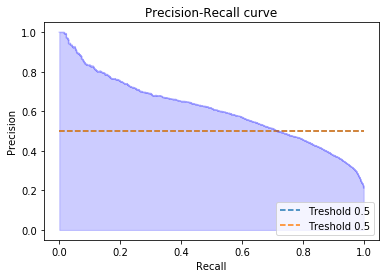

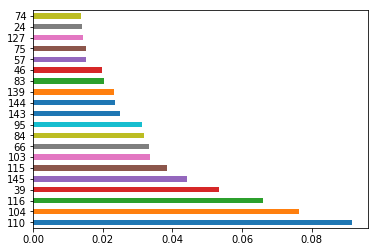

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[39180  4926]
 [ 4188  2196]]
[[TN, FP]
[FN, TP]]
Accuracy: 0.82


Other Metrics :

              precision    recall  f1-score   support

       False       0.90      0.89      0.90     44106
        True       0.31      0.34      0.33      6384

   micro avg       0.82      0.82      0.82     50490
   macro avg       0.61      0.62      0.61     50490
weighted avg       0.83      0.82      0.82     50490

----------------------------------------------------------

f1=0.325 auc=0.252 ap=0.253


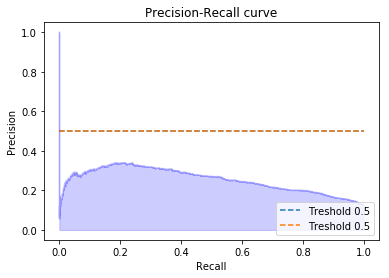

array([0.12816254, 0.13171708, 0.13171708, ..., 0.76945181, 0.76945181,
       0.76945181])
{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [9]:
# -----------------------
# ALGO : RANDOM FOREST
# -----------------------

from sklearn.ensemble import RandomForestClassifier
#, n_estimators=100, max_features='auto', max_depth=5, criterion='entropy', class_weight="balanced"
clf = RandomForestClassifier(random_state=0, class_weight="balanced", max_depth=5).fit(X_train, y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', clf, X_train, y_train[y_to_be_considered], None, do_precision_recall_curve=True, do_features_importance=True, threshold=threshold)
show_model_accuracy('RandomForestClassifier - Test', clf, X_test, y_test[y_to_be_considered], None, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

# proba : to be shown by prediction, bien comprendre !
probas = clf.predict_proba(X_test)[:,1]
pprint(np.sort(probas))
pprint(clf.get_params())

# clf.decision_path(X_test)

In [ ]:
# -----------------------
# ALGO : MLPClassifier - Neural Network (cf. Module+4 for tuning)
# -----------------------
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(hidden_layer_sizes = [130, 130], solver='lbfgs',
                     random_state = 0).fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('MLPClassifier - Neural Network - Train', nnclf, X_train_scaled, y_train[y_to_be_considered], X_train_scaled.columns, do_roc_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('MLPClassifier - Neural Network - Test', nnclf, X_test_scaled, y_test[y_to_be_considered], X_test_scaled.columns, do_roc_curve=True, do_features_importance=False, threshold=threshold)

# proba : to be shown by prediction, bien comprendre !
#print(pd.DataFrame(nnclf.predict_proba(X_test_scaled)[:,1]))

In [ ]:
# -----------------------
# ALGO : XGBOOST (cf. Module+4 for tuning)
# -----------------------
from xgboost import XGBClassifier

xgbc = XGBClassifier().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('XGBClassifier - Train', xgbc, X_train_scaled, y_train[y_to_be_considered], pX_columns=None, do_roc_curve=True, do_precision_recall_curve=True, do_precision_recall_vs_treshold=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('XGBClassifier - Test', xgbc, X_test_scaled, y_test[y_to_be_considered], pX_columns=None, do_roc_curve=True, do_precision_recall_curve=True, do_precision_recall_vs_treshold=True, do_features_importance=True, threshold=threshold)

In [ ]:
# -----------------------
# ALGO : XGBOOST (cf. Module+4 for tuning)
# -----------------------
from xgboost import XGBClassifier

xgbc = XGBClassifier().fit(X_train, y_train[y_to_be_considered])

show_model_accuracy('XGBClassifier - Train', xgbc, X_train, y_train[y_to_be_considered], pX_columns=None, do_roc_curve=True, do_precision_recall_curve=True, do_precision_recall_vs_treshold=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('XGBClassifier - Test', xgbc, X_test, y_test[y_to_be_considered], pX_columns=None, do_roc_curve=True, do_precision_recall_curve=True, do_precision_recall_vs_treshold=True, do_features_importance=True, threshold=threshold)